<img src="images\GRU_formulas.jpg" width=800>
<img src="images\GRU_shapes.jpg" width=200>
<img src="images\GRU_derivatives.jpg" width=800>

In [171]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5


def load_data_txt(filename, dimensions, max_len=None):
    f = open(filename, "r")
    data = []
    print("loading data")
    for line in f:
        for c in line:
            if ord(c)-ord('A') > 0 and ord(c)-ord('A') < dimensions:
                new_data = []
                for i in range(0, dimensions):
                    new_data.append([0])
                    
                new_data[ord(c)-ord('A')] = [1]
                data.append(new_data)
                if max_len != None:
                    if len(data) >= max_len:
                        print("all loaded")    
                        return data
                    
    print("all loaded")    
    return data
            
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":  
            x = activated_value
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return activated_value

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, last_activation=None):
        new_layer = Layer(input_size, output_size, last_activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].h[-1]
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].h[-1]
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps):
        gradient, loss = self.layers[-1].der_MSE(target)
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].h
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps)
        return loss
    
    def predict(self, input_data):
        next_letter = []
        out_letter = []
        for i in range(0, len(input_data)):
            next_letter = self.forward_pass(input_data[i])
            
        out_letter = next_letter
        print_output = ""
        for i in range(500, 700):
            maximum = 0;
            max_index = 0;
            for k in range(0, 3):
                if next_letter[k][0] > maximum:
                    maximum = next_letter[k][0]
                    max_index = k
            out_letter = np.empty(next_letter.shape)
            out_letter.fill(0)
            out_letter[max_index,0] = 1
            print_output += chr(ord('A')+max_index)
            next_letter = self.forward_pass(out_letter)
        print(print_output)
    
class Layer():
    
    def __init__(self, input_size, output_size, last_activation=None):
        self.input_size = input_size # N
        self.output_size = output_size # M
        self.last_activation = last_activation
        
        self.Wz = self.weights_init(output_size, input_size) # NxM
        self.Wr = self.weights_init(output_size, input_size) # NxM
        self.Wh = self.weights_init(output_size, input_size) # NxM
        
        self.Uz = self.weights_init(output_size, output_size) # NxN
        self.Ur = self.weights_init(output_size, output_size) # NxN
        self.Uh = self.weights_init(output_size, output_size) # NxN
        
        self.bz = self.weights_init(output_size, 1, bias=True) # Nx1
        self.br = self.weights_init(output_size, 1, bias=True) # Nx1
        self.bh = self.weights_init(output_size, 1, bias=True) # Nx1
        
        # T = time steps, starts with 0
        
        self.z       = np.empty((0,output_size,1)) # TxNx1, z(t) = Nx1
        self.r       = np.empty((0,output_size,1)) # TxNx1, r(t) = Nx1
        self.h_tilde = np.empty((0,output_size,1)) # TxNx1, h_tilde(t) = Nx1
        self.h       = np.empty((0,output_size,1)) # TxNx1, h(t) = Nx1
        self.inputs  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
    def weights_init(self, rows, cols, bias=False):
        variance = math.sqrt(1/self.input_size)
        if bias:
            return np.random.uniform(0,0.01,(rows, cols))
        return np.random.uniform(-variance,variance,(rows, cols))
    
    
    def forward_pass(self, input_data):
        
        self.inputs = np.append(self.inputs, [input_data])
        prev_h = []
        if len(self.h) > 0:
            prev_h = self.h[-1]
        else:
            prev_h = np.empty((self.h.shape[1], self.h.shape[2]))
            prev_h.fill(0)
        
        new_z = self.Wz @ input_data + self.Uz @ prev_h + self.bz
        new_z = activation_function(new_z, "sigmoid")
        self.z = np.append(self.z, [new_z], axis=0)
        
        new_r = self.Wr @ input_data + self.Ur @ prev_h + self.br
        new_r = activation_function(new_r, "sigmoid")
        self.r = np.append(self.r, [new_r], axis=0)
        
        new_h_tilde = self.Wh @ input_data + self.r[-1] * (self.Uh @ prev_h) + self.bh
        new_h_tilde = activation_function(new_h_tilde, "tanh")
        self.h_tilde = np.append(self.h_tilde, [new_h_tilde], axis=0)
        
        new_h = self.z[-1] * self.h_tilde[-1] + (1 - self.z[-1]) * prev_h
        self.h = np.append(self.h, [new_h], axis=0)
        
        
        if len(self.z) > 30:
            self.z = np.delete(self.z, 0, 0)
        if len(self.r) > 30:
            self.r = np.delete(self.r, 0, 0)
        if len(self.h_tilde) > 30:
            self.h_tilde = np.delete(self.h_tilde, 0, 0)
        if len(self.h) > 30:
            self.h = np.delete(self.h, 0, 0)
            
            
        
    def clear_memory(self):
        self.z       = np.empty((0,self.output_size,1))
        self.r       = np.empty((0,self.output_size,1))
        self.h_tilde = np.empty((0,self.output_size,1))
        self.h       = np.empty((0,self.output_size,1))
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
        
    def der_MSE(self, target):
        if self.last_activation != None:
            return 2*(self.h[-1] - target) * activation_function(self.h[-1], self.last_activation, derivative=True, activated_value=self.h[-1]), np.power(target - self.h[-1], 2)
        return 2*(self.h[-1] - target), np.power(target - self.h[-1], 2)
     
    
    def descent(self, gradient, input_data, learning_rate, max_steps):
        input_matrix = np.array(input_data)
        first_index = max(len(self.h) - max_steps, 0)
        
        step = 0
        inputs_reshaped = np.sum(self.inputs[first_index], axis=0, keepdims=True)
        inputs_reshaped = np.tile(inputs_reshaped, (self.output_size, 1))
        
        dr_Wr = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        dr_Wr *= (inputs_reshaped)
        #dr_Wr = np.tile(dr_Wr, (1, self.input_size))
        
        dz_Wr = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        dz_Wr *= (inputs_reshaped)
        
        dhtilde_Wr = activation_function(self.h_tilde[first_index], "tanh", derivative=True, activated_value=self.h_tilde[first_index])
        dhtilde_Wr *= (inputs_reshaped)
        
        dh_Wr = dz_Wr * (-self.h_tilde[first_index]) + dhtilde_Wr * (1 - self.z[first_index])
        
        dr_x = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        dr_x = np.tile(dr_x, (1, self.input_size))
        dr_x = np.sum(dr_x, axis=0, keepdims=True).T
        Wr_reshaped = np.sum(self.Wr, axis=0, keepdims=True).T
        dr_x *= (Wr_reshaped)
        
        dz_x = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        dz_x = np.tile(dz_x, (1, self.input_size))
        dz_x = np.sum(dz_x, axis=0, keepdims=True).T
        Wz_reshaped = np.sum(self.Wz, axis=0, keepdims=True).T
        dz_x *= (Wz_reshaped)
        
        dhtilde_x = activation_function(self.h_tilde[-1], "tanh", derivative=True, activated_value=self.h_tilde[-1])
        dhtilde_x = np.tile(dhtilde_x, (1, self.input_size)) # from Nx1 to NxM
        dhtilde_x = np.sum(dhtilde_x, axis=0, keepdims=True).T # from NxM to Mx1
        Wh_reshaped = np.sum(self.Wh, axis=0, keepdims=True).T # from NxM to Mx1
        prev_h = np.empty((self.output_size, 1)) if len(self.h) < 2 else self.h[-2]
        Uhprev_h = np.sum(np.tile(self.Uh @ prev_h, (1, self.input_size)), axis=0, keepdims=True).T
        dhtilde_x *= (Wh_reshaped + dr_x * Uhprev_h)
        
        h_subtract = np.tile(prev_h - self.h_tilde[-1], (1, self.input_size))
        h_subtract = np.sum(h_subtract, axis=0, keepdims=True).T
        one_minus = np.tile((1 - self.z[-1]), (1, self.input_size))
        one_minus = np.sum(one_minus, axis=0, keepdims=True).T
        dh_x = dz_x * h_subtract + dhtilde_x * one_minus
        
        step = 1
        
        while step + first_index < len(self.h): 
            
            inputs_reshaped = np.sum(self.inputs[first_index+step], axis=0, keepdims=True)
            inputs_reshaped = np.tile(inputs_reshaped, (self.output_size, 1)) # X goes from Mx1 to Nx1
            #print("first_index: " + str(first_index))
        
            """Wr gradient steps"""
            dr_Wr = activation_function(self.r[first_index+step], "sigmoid", \
                                        derivative=True, activated_value=self.r[first_index+step])
            dr_Wr *= (inputs_reshaped + self.Ur @ dh_Wr)
            
            dz_Wr = activation_function(self.z[first_index+step], "sigmoid", \
                                        derivative=True, activated_value=self.z[first_index+step])
            dz_Wr *= (inputs_reshaped + self.Uz @ dh_Wr)
            
            dhtilde_Wr = activation_function(self.h_tilde[first_index+step], "tanh", \
                                             derivative=True, activated_value=self.h_tilde[first_index+step])
            dhtilde_Wr *= (inputs_reshaped + dr_Wr * \
                           (self.Uh @ self.h[first_index+step-1]))
            
            dh_Wr = dz_Wr * (self.h[first_index+step-1] - self.h_tilde[first_index+step]) \
            + dh_Wr * self.z[first_index+step] + dhtilde_Wr * (1 - self.z[first_index+step])
            
    
            step+=1
                
        
        dh_Wr *= gradient
        dh_Wr = np.tile(dh_Wr, (1, self.input_size))
        
        self.Wr -= learning_rate * dh_Wr
        
        return dh_x
    

In [172]:
network = RNN(0.005)
network.add_layer(3, 1)
network.add_layer(1, 3,"softmax")

In [173]:
#input_data = load_data_txt("FinalText.txt", 5, 150)


input_data = [
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
]


---------------
epoch 0
---------------
epoch 0
learning rate: 0.0049987503124218945
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.34364556]
 [0.26332703]
 [0.22501327]]


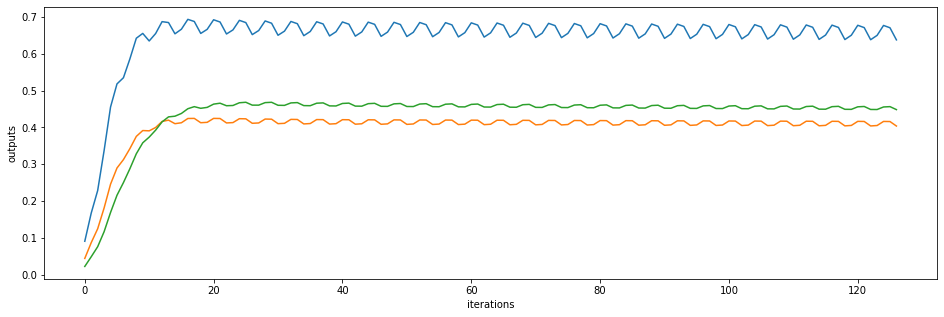

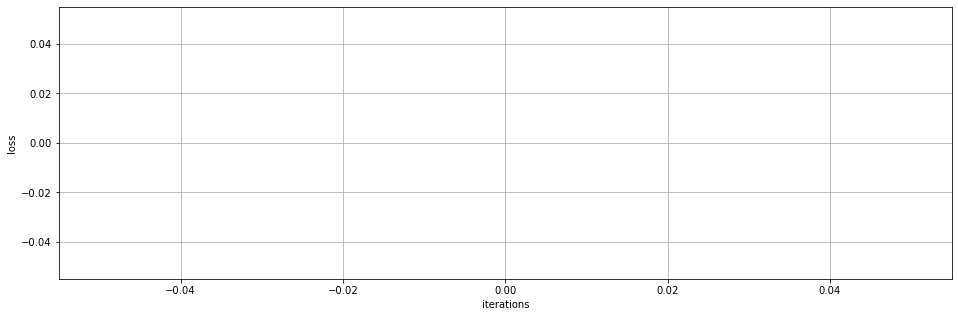

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 1
---------------
epoch 2
---------------
epoch 3
---------------
epoch 4
---------------
epoch 5
---------------
epoch 6
---------------
epoch 7
---------------
epoch 8
---------------
epoch 9
---------------
epoch 10
---------------
epoch 10
learning rate: 0.004986270602675783
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.29974347]
 [0.2680677 ]
 [0.20739314]]


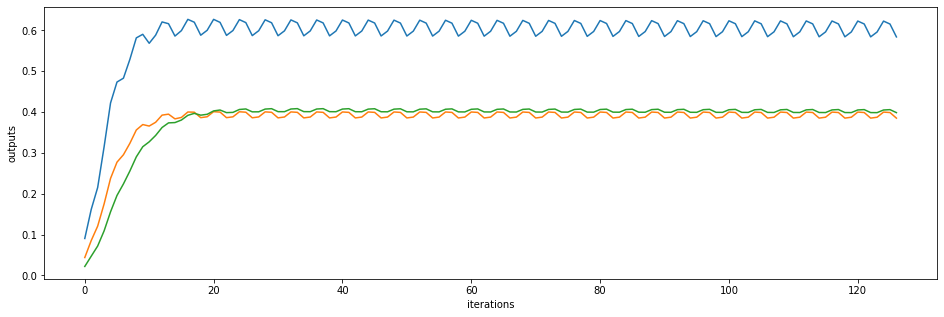

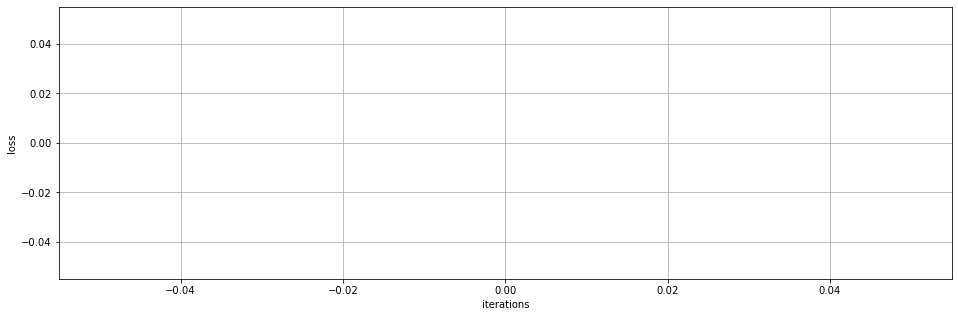

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 11
---------------
epoch 12
---------------
epoch 13
---------------
epoch 14
---------------
epoch 15
---------------
epoch 16
---------------
epoch 17
---------------
epoch 18
---------------
epoch 19
---------------
epoch 20
---------------
epoch 20
learning rate: 0.004973822049347898
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.27875574]
 [0.26977445]
 [0.200599  ]]


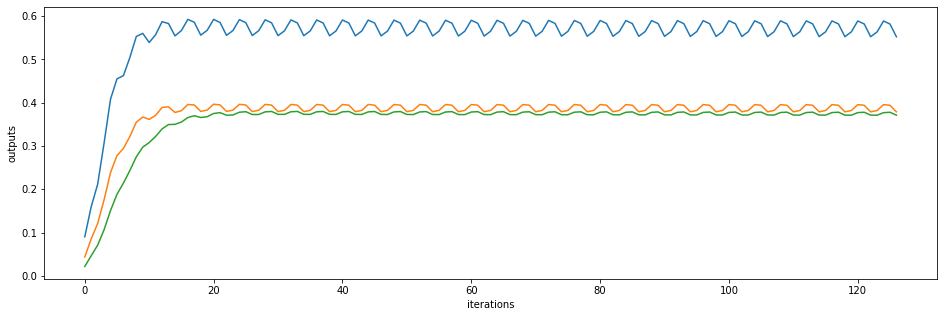

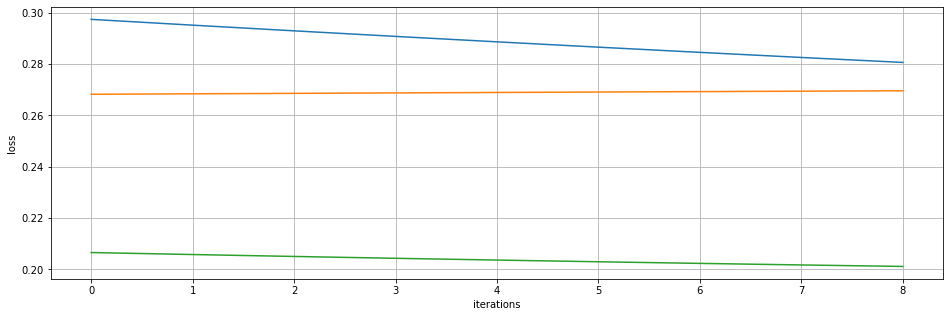

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 21
---------------
epoch 22
---------------
epoch 23
---------------
epoch 24
---------------
epoch 25
---------------
epoch 26
---------------
epoch 27
---------------
epoch 28
---------------
epoch 29
---------------
epoch 30
---------------
epoch 30
learning rate: 0.004961404574654188
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.26211929]
 [0.27124774]
 [0.19615486]]


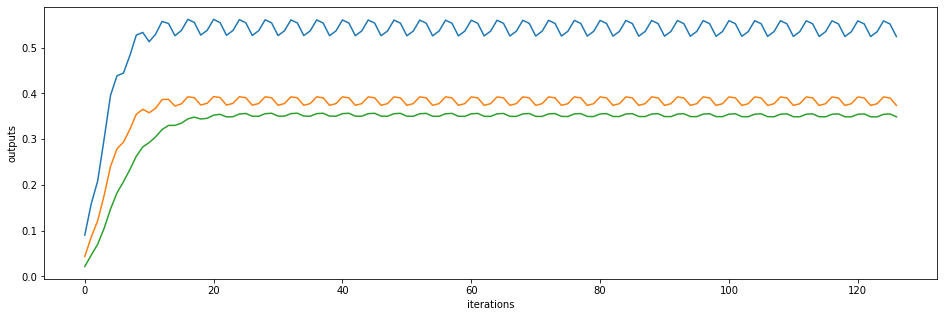

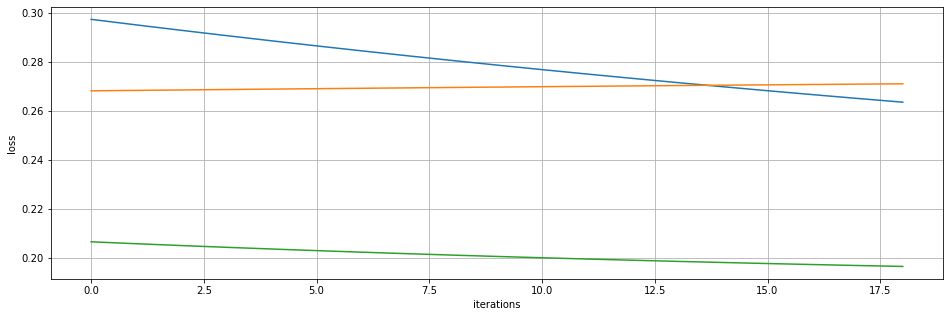

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 31
---------------
epoch 32
---------------
epoch 33
---------------
epoch 34
---------------
epoch 35
---------------
epoch 36
---------------
epoch 37
---------------
epoch 38
---------------
epoch 39
---------------
epoch 40
---------------
epoch 40
learning rate: 0.004949018101004792
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.24913639]
 [0.27244456]
 [0.19326443]]


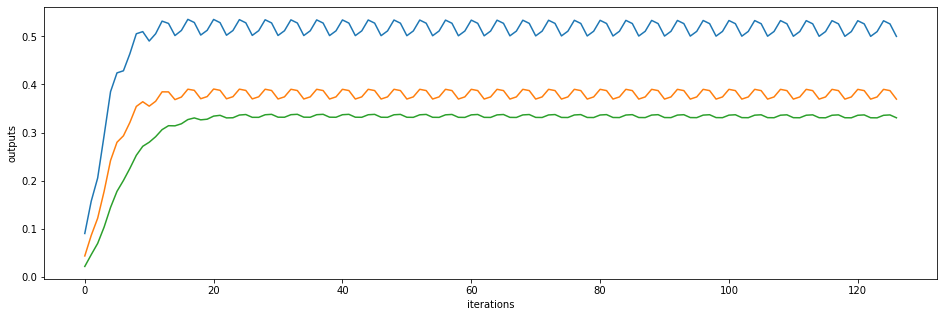

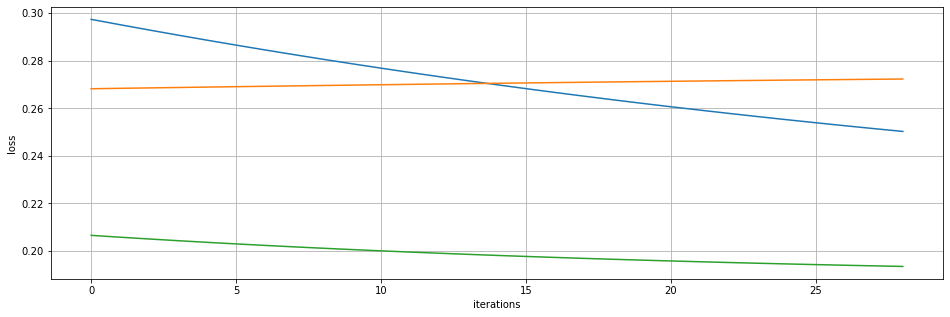

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 41
---------------
epoch 42
---------------
epoch 43
---------------
epoch 44
---------------
epoch 45
---------------
epoch 46
---------------
epoch 47
---------------
epoch 48
---------------
epoch 49
---------------
epoch 50
---------------
epoch 50
learning rate: 0.004936662551003561
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.23901756]
 [0.27336838]
 [0.19137537]]


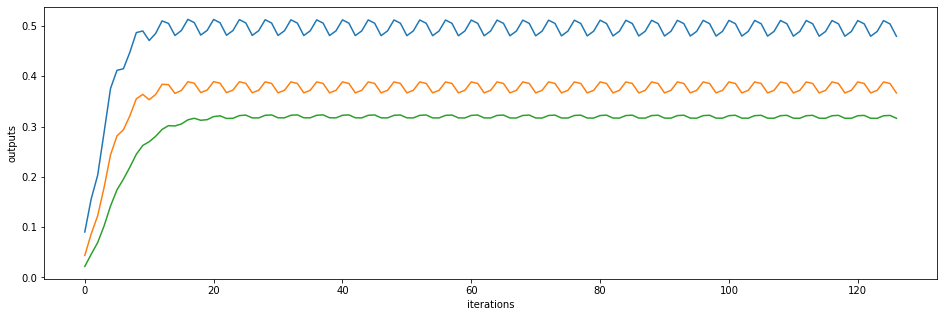

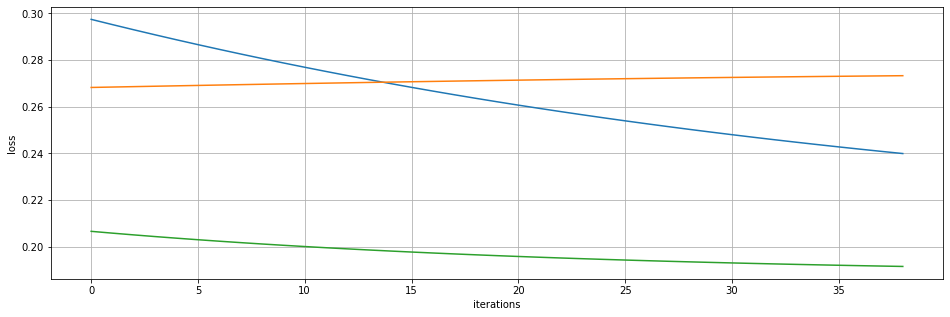

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 51
---------------
epoch 52
---------------
epoch 53
---------------
epoch 54
---------------
epoch 55
---------------
epoch 56
---------------
epoch 57
---------------
epoch 58
---------------
epoch 59
---------------
epoch 60
---------------
epoch 60
learning rate: 0.004924337847447569
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.23107138]
 [0.27404789]
 [0.19012778]]


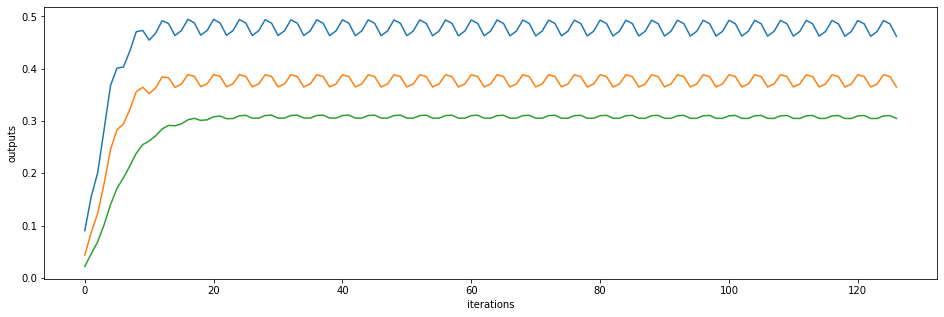

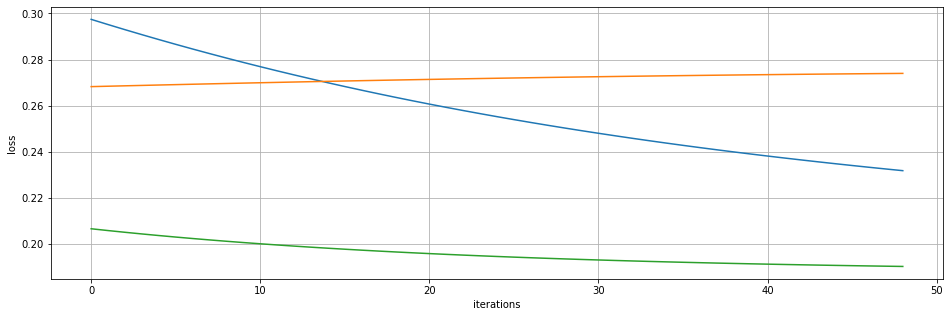

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 61
---------------
epoch 62
---------------
epoch 63
---------------
epoch 64
---------------
epoch 65
---------------
epoch 66
---------------
epoch 67
---------------
epoch 68
---------------
epoch 69
---------------
epoch 70
---------------
epoch 70
learning rate: 0.0049120439133266275
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22475568]
 [0.27452075]
 [0.18929339]]


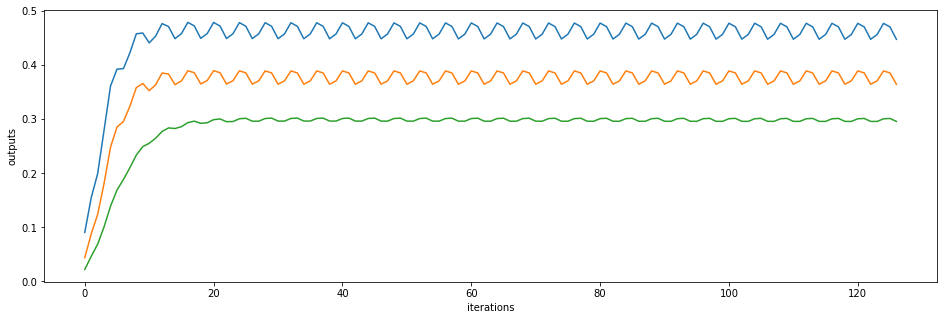

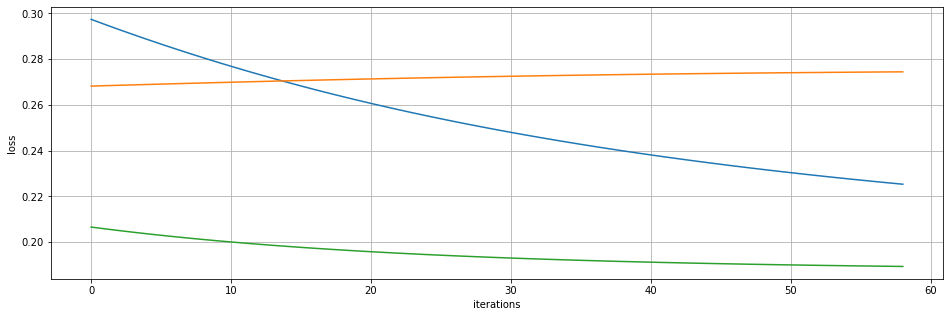

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 71
---------------
epoch 72
---------------
epoch 73
---------------
epoch 74
---------------
epoch 75
---------------
epoch 76
---------------
epoch 77
---------------
epoch 78
---------------
epoch 79
---------------
epoch 80
---------------
epoch 80
learning rate: 0.004899780671822817
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21966831]
 [0.27482273]
 [0.18872863]]


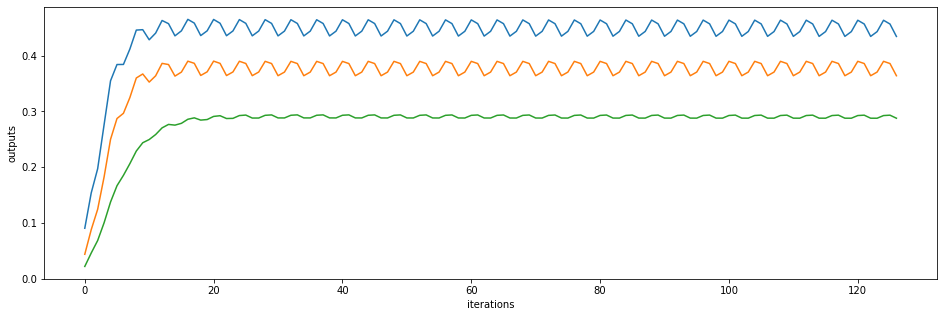

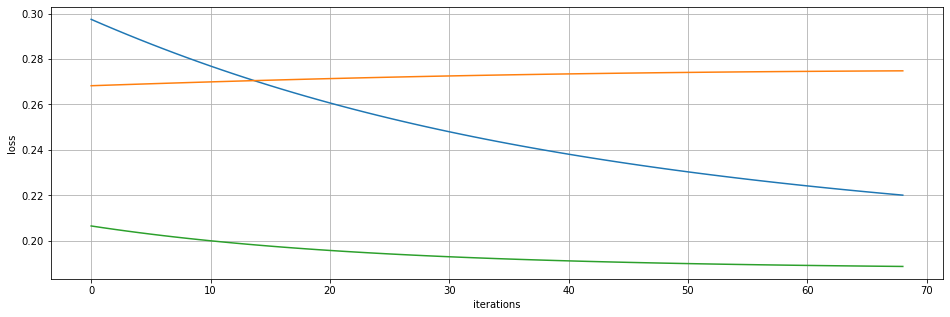

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 81
---------------
epoch 82
---------------
epoch 83
---------------
epoch 84
---------------
epoch 85
---------------
epoch 86
---------------
epoch 87
---------------
epoch 88
---------------
epoch 89
---------------
epoch 90
---------------
epoch 90
learning rate: 0.004887548046309995
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21560951]
 [0.27491239]
 [0.18835412]]


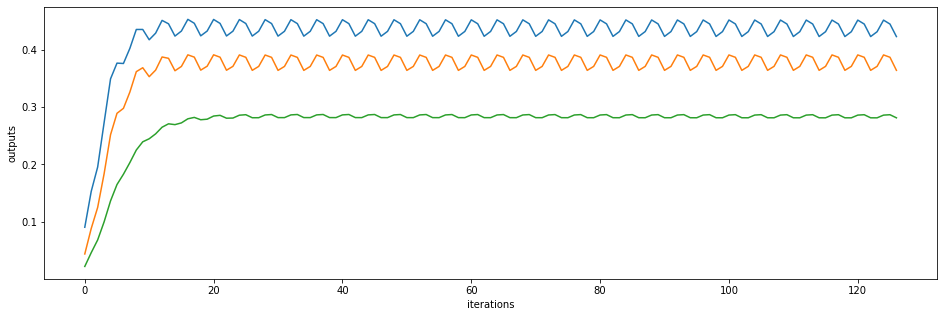

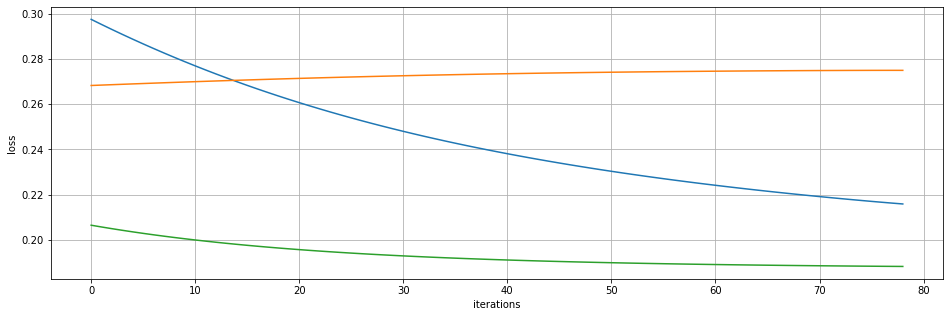

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 91
---------------
epoch 92
---------------
epoch 93
---------------
epoch 94
---------------
epoch 95
---------------
epoch 96
---------------
epoch 97
---------------
epoch 98
---------------
epoch 99
---------------
epoch 100
---------------
epoch 100
learning rate: 0.004875345960353321
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21579188]
 [0.27205191]
 [0.18855591]]


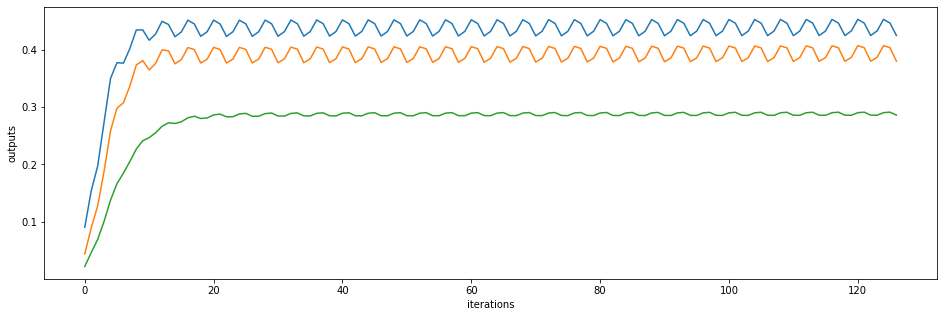

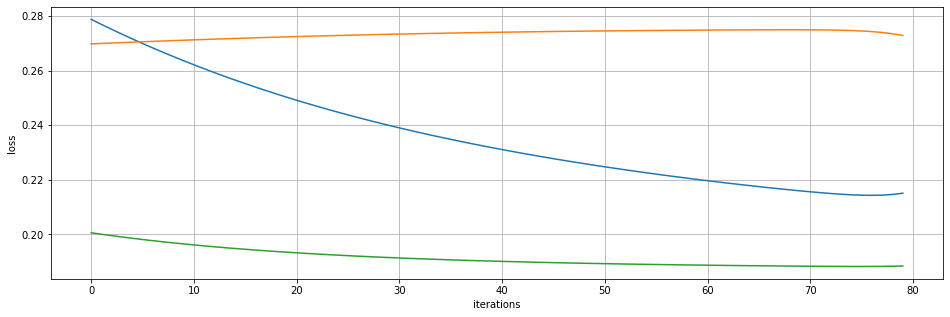

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 101
---------------
epoch 102
---------------
epoch 103
---------------
epoch 104
---------------
epoch 105
---------------
epoch 106
---------------
epoch 107
---------------
epoch 108
---------------
epoch 109
---------------
epoch 110
---------------
epoch 110
learning rate: 0.004863174337708778
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22328447]
 [0.26437178]
 [0.19020771]]


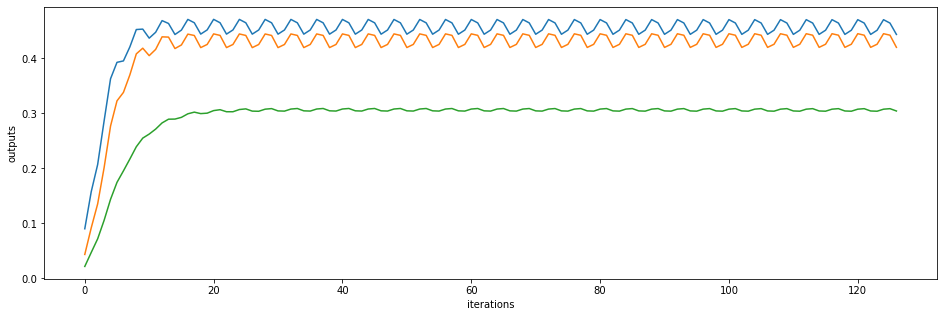

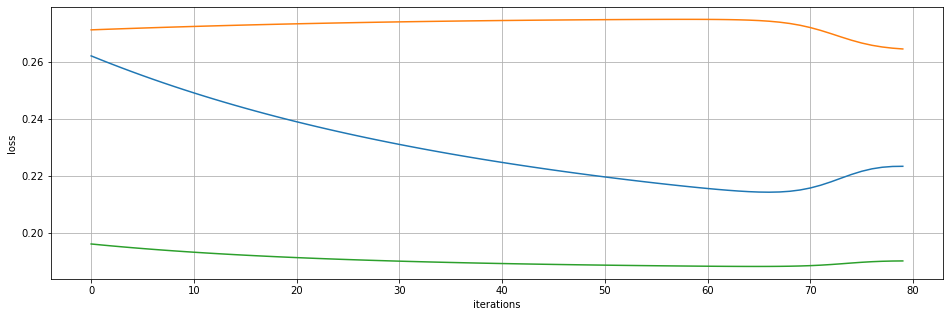

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 111
---------------
epoch 112
---------------
epoch 113
---------------
epoch 114
---------------
epoch 115
---------------
epoch 116
---------------
epoch 117
---------------
epoch 118
---------------
epoch 119
---------------
epoch 120
---------------
epoch 120
learning rate: 0.0048510331023227
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21973401]
 [0.26425216]
 [0.18966007]]


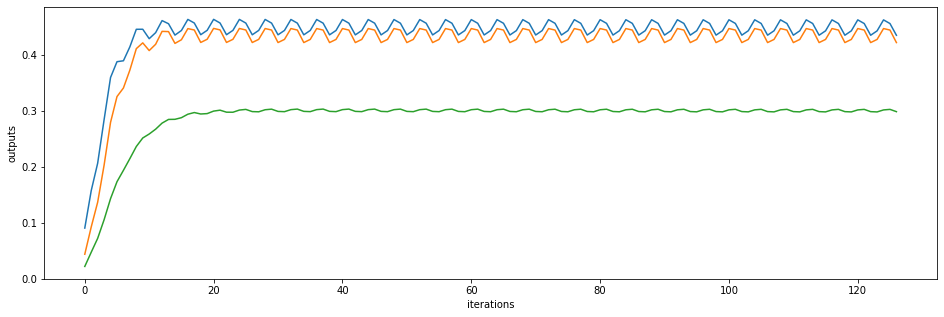

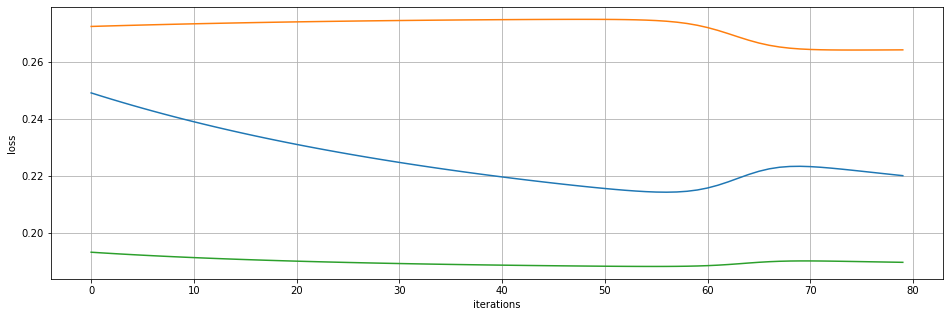

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 121
---------------
epoch 122
---------------
epoch 123
---------------
epoch 124
---------------
epoch 125
---------------
epoch 126
---------------
epoch 127
---------------
epoch 128
---------------
epoch 129
---------------
epoch 130
---------------
epoch 130
learning rate: 0.004838922178331291
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21630737]
 [0.26440705]
 [0.18917227]]


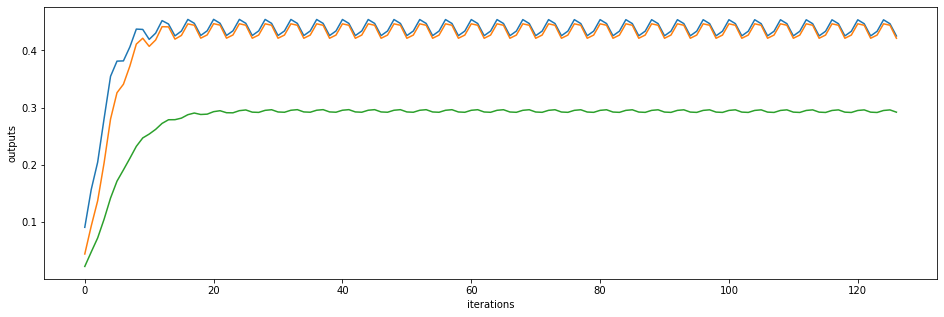

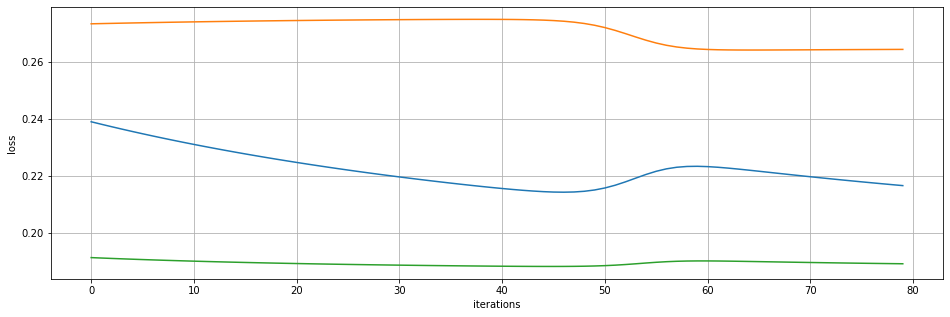

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
---------------
epoch 131
---------------
epoch 132
---------------
epoch 133
---------------
epoch 134
---------------
epoch 135
---------------
epoch 136
---------------
epoch 137
---------------
epoch 138
---------------
epoch 139
---------------
epoch 140
---------------
epoch 140
learning rate: 0.0048268414900601575
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21343676]
 [0.26450432]
 [0.18881815]]


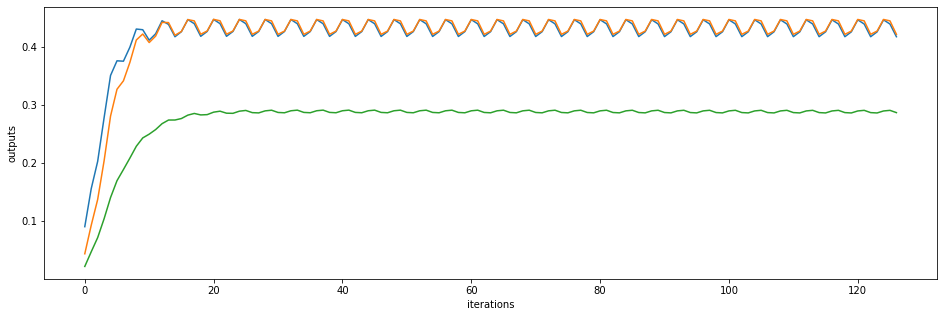

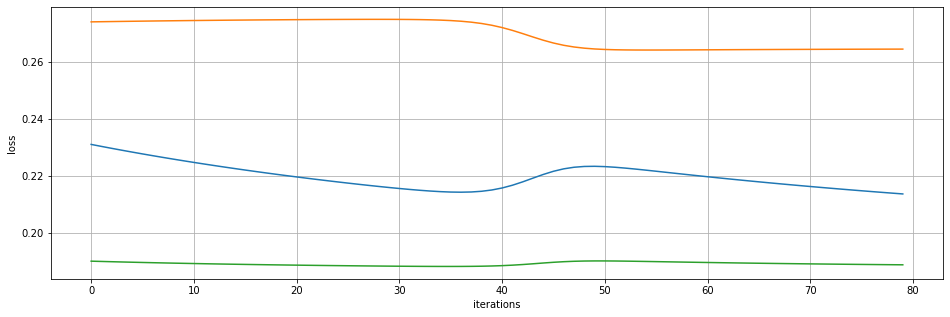

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 141
---------------
epoch 142
---------------
epoch 143
---------------
epoch 144
---------------
epoch 145
---------------
epoch 146
---------------
epoch 147
---------------
epoch 148
---------------
epoch 149
---------------
epoch 150
---------------
epoch 150
learning rate: 0.004814790962023829
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.21100334]
 [0.26455506]
 [0.18855744]]


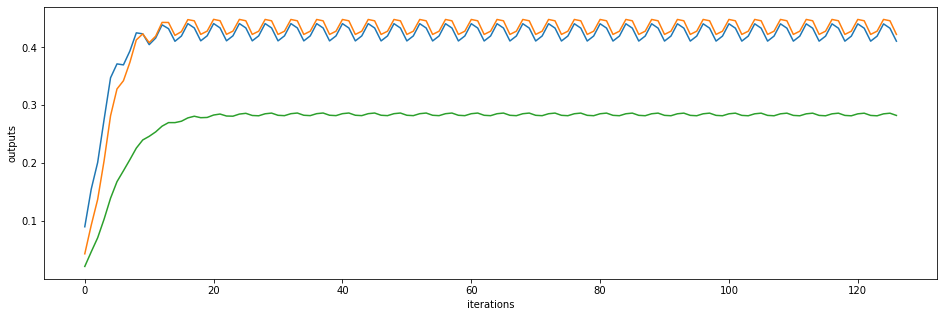

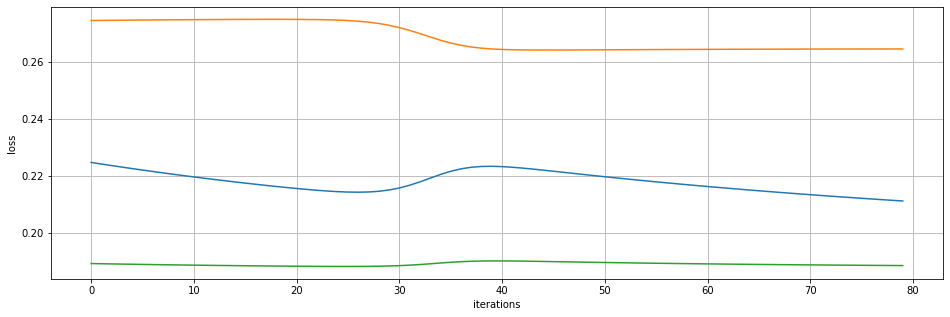

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 151
---------------
epoch 152
---------------
epoch 153
---------------
epoch 154
---------------
epoch 155
---------------
epoch 156
---------------
epoch 157
---------------
epoch 158
---------------
epoch 159
---------------
epoch 160
---------------
epoch 160
learning rate: 0.00480277051892529
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20891686]
 [0.26457   ]
 [0.18836279]]


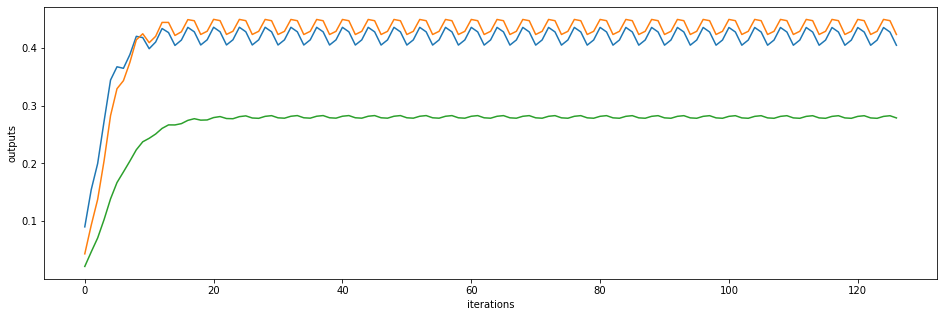

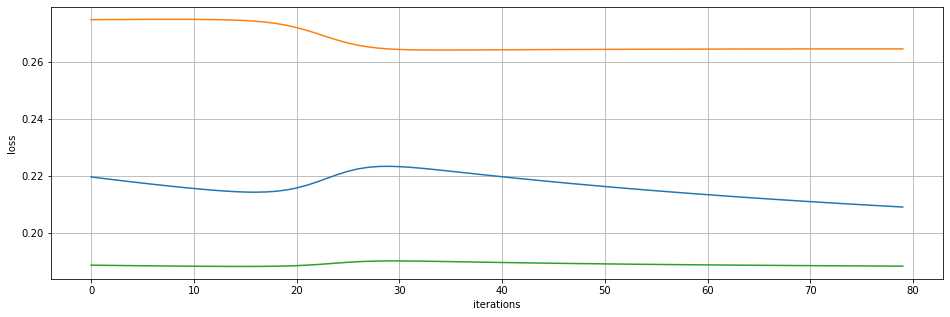

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 161
---------------
epoch 162
---------------
epoch 163
---------------
epoch 164
---------------
epoch 165
---------------
epoch 166
---------------
epoch 167
---------------
epoch 168
---------------
epoch 169
---------------
epoch 170
---------------
epoch 170
learning rate: 0.004790780085655512
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20710973]
 [0.26455767]
 [0.1882156 ]]


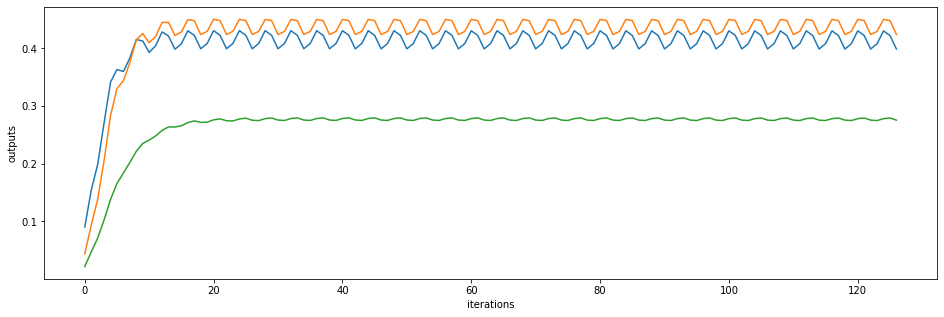

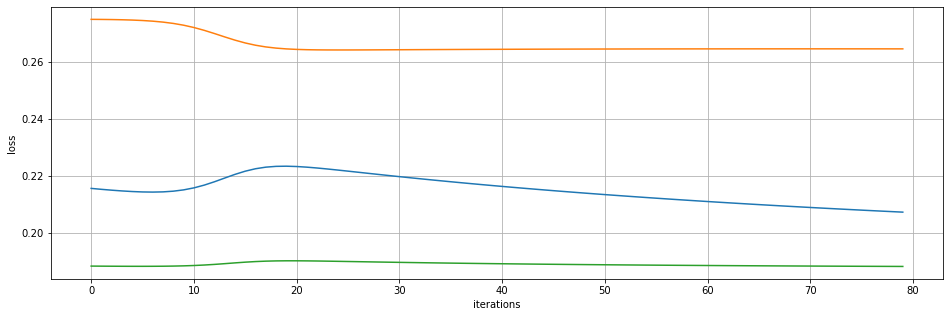

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 171
---------------
epoch 172
---------------
epoch 173
---------------
epoch 174
---------------
epoch 175
---------------
epoch 176
---------------
epoch 177
---------------
epoch 178
---------------
epoch 179
---------------
epoch 180
---------------
epoch 180
learning rate: 0.004778819587292977
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20553053]
 [0.26452478]
 [0.18810298]]


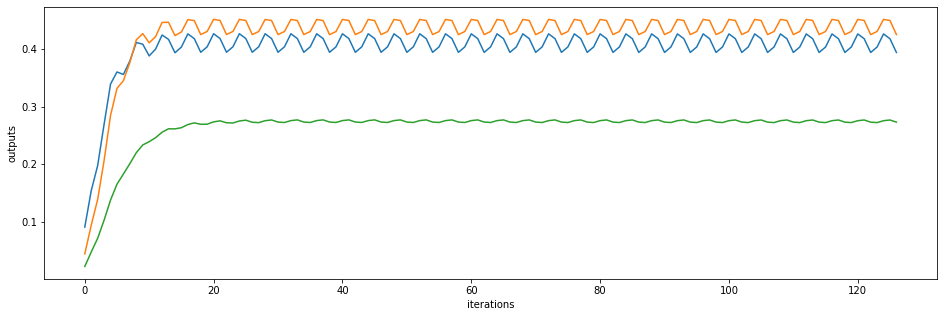

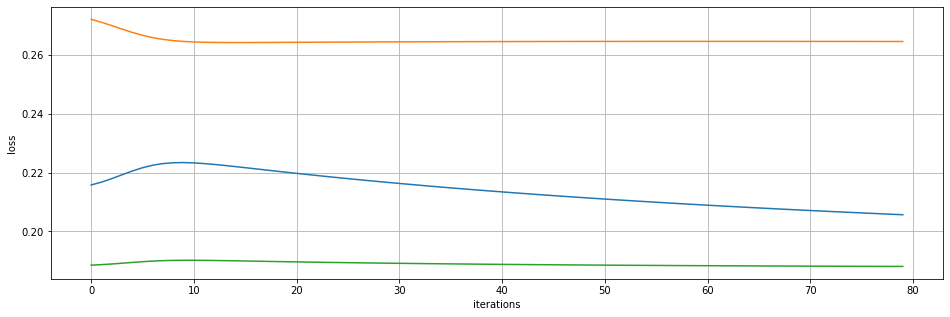

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 181
---------------
epoch 182
---------------
epoch 183
---------------
epoch 184
---------------
epoch 185
---------------
epoch 186
---------------
epoch 187
---------------
epoch 188
---------------
epoch 189
---------------
epoch 190
---------------
epoch 190
learning rate: 0.004766888949103218
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20413957]
 [0.26447662]
 [0.18801586]]


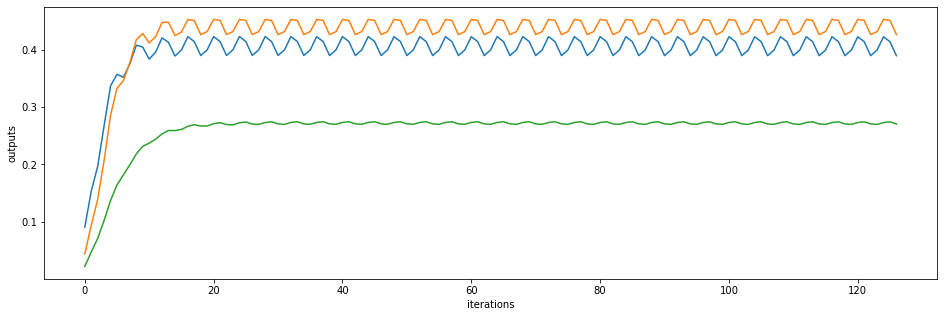

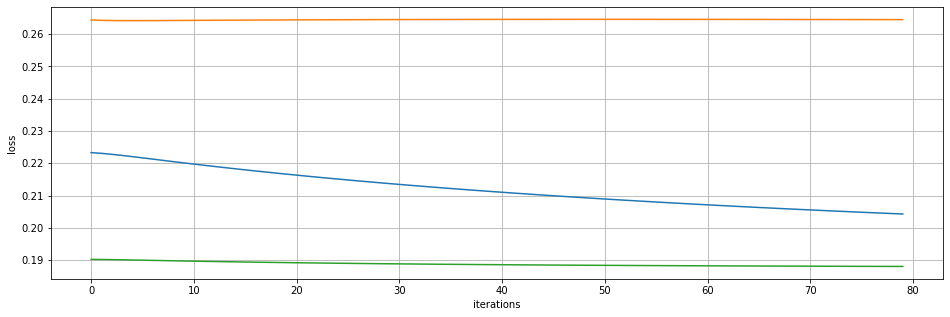

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 191
---------------
epoch 192
---------------
epoch 193
---------------
epoch 194
---------------
epoch 195
---------------
epoch 196
---------------
epoch 197
---------------
epoch 198
---------------
epoch 199
---------------
epoch 200
---------------
epoch 200
learning rate: 0.0047549880965383415
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20290573]
 [0.26441731]
 [0.18794774]]


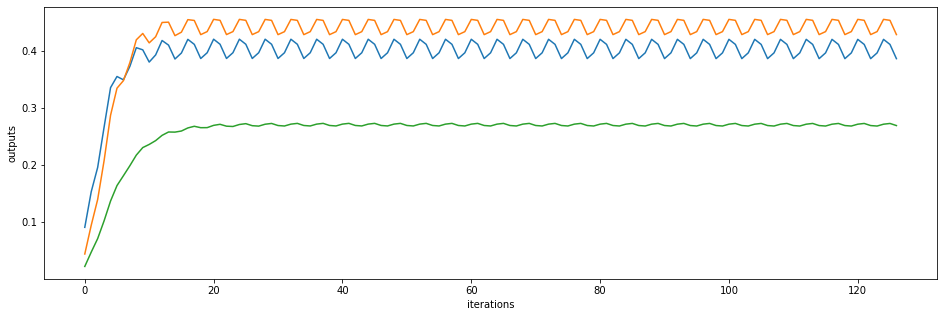

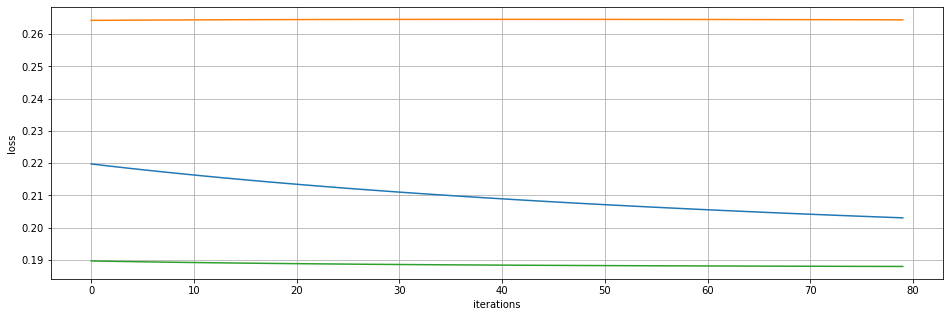

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 201
---------------
epoch 202
---------------
epoch 203
---------------
epoch 204
---------------
epoch 205
---------------
epoch 206
---------------
epoch 207
---------------
epoch 208
---------------
epoch 209
---------------
epoch 210
---------------
epoch 210
learning rate: 0.0047431169552365725
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20180438]
 [0.26435009]
 [0.18789393]]


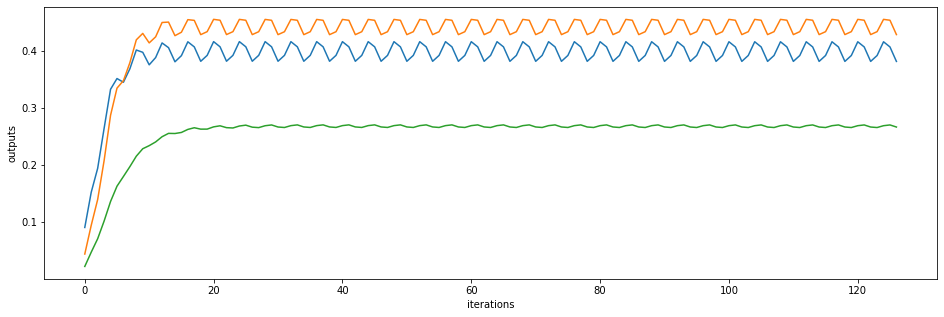

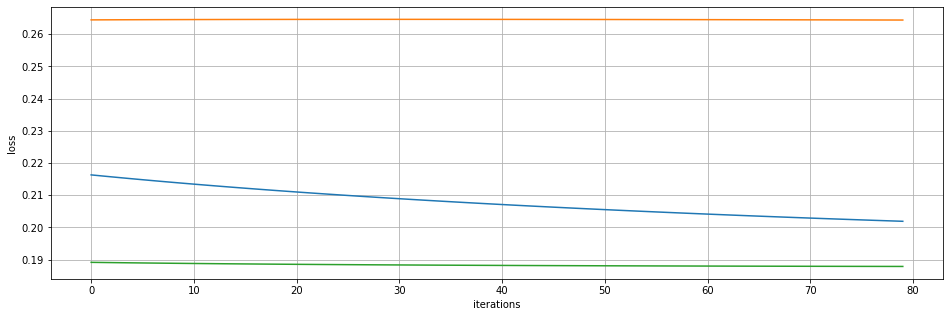

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 211
---------------
epoch 212
---------------
epoch 213
---------------
epoch 214
---------------
epoch 215
---------------
epoch 216
---------------
epoch 217
---------------
epoch 218
---------------
epoch 219
---------------
epoch 220
---------------
epoch 220
learning rate: 0.004731275451021783
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.20081572]
 [0.26427747]
 [0.18785097]]


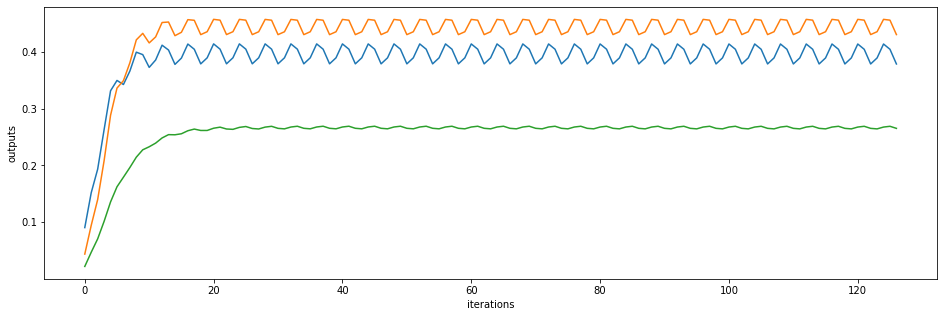

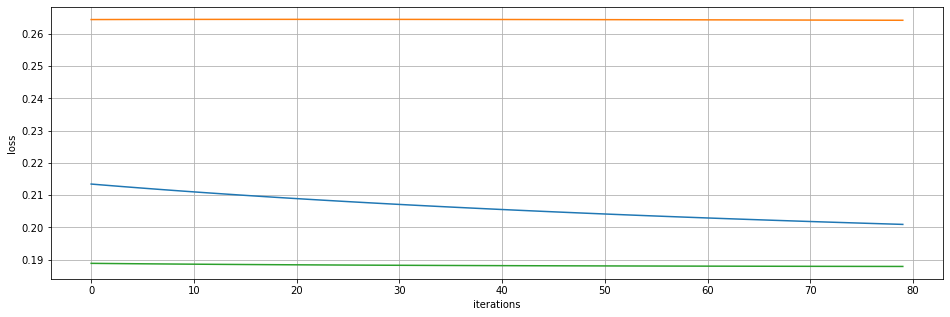

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 221
---------------
epoch 222
---------------
epoch 223
---------------
epoch 224
---------------
epoch 225
---------------
epoch 226
---------------
epoch 227
---------------
epoch 228
---------------
epoch 229
---------------
epoch 230
---------------
epoch 230
learning rate: 0.004719463509903033
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.19992371]
 [0.26420141]
 [0.18781632]]


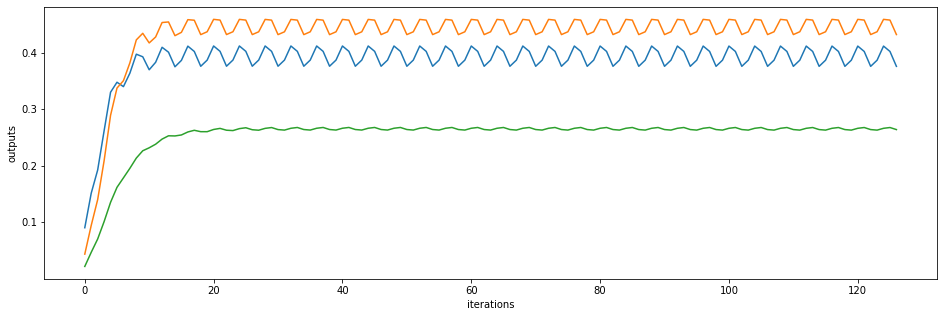

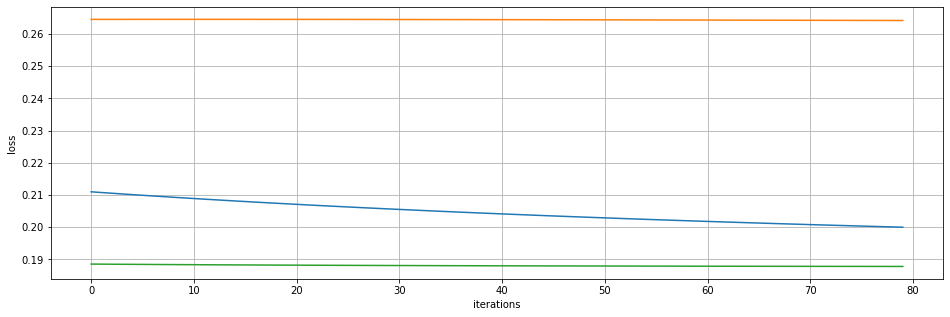

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 231
---------------
epoch 232
---------------
epoch 233
---------------
epoch 234
---------------
epoch 235
---------------
epoch 236
---------------
epoch 237
---------------
epoch 238
---------------
epoch 239
---------------
epoch 240
---------------
epoch 240
learning rate: 0.004707681058074104
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.19911521]
 [0.2641234 ]
 [0.18778806]]


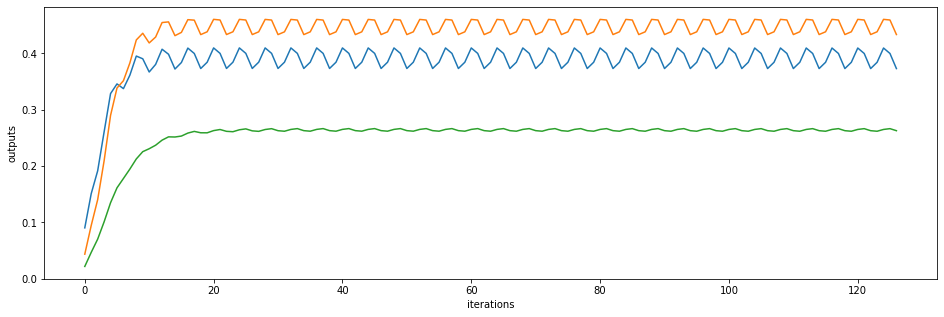

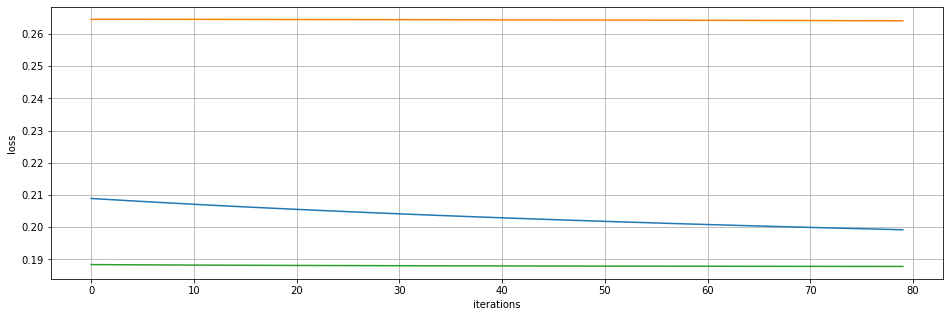

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 241
---------------
epoch 242
---------------
epoch 243
---------------
epoch 244
---------------
epoch 245
---------------
epoch 246
---------------
epoch 247
---------------
epoch 248
---------------
epoch 249
---------------
epoch 250
---------------
epoch 250
learning rate: 0.004695928021913037
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.19837936]
 [0.26404462]
 [0.18776476]]


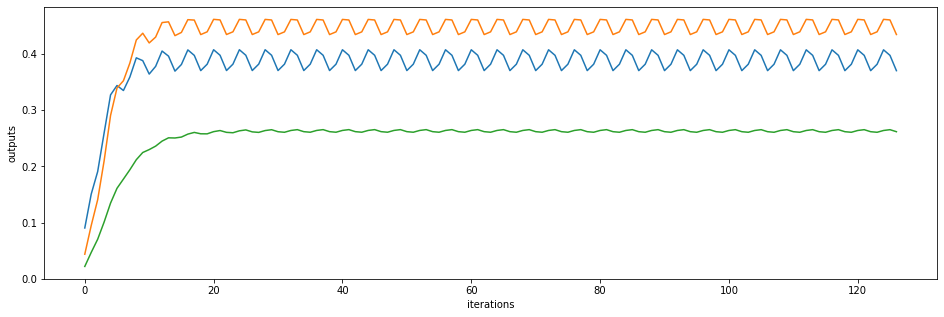

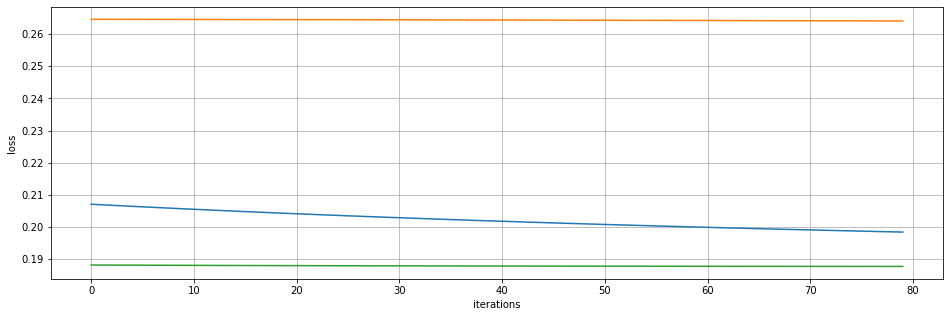

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 251
---------------
epoch 252
---------------
epoch 253
---------------
epoch 254
---------------
epoch 255
---------------
epoch 256
---------------
epoch 257
---------------
epoch 258
---------------
epoch 259
---------------
epoch 260
---------------
epoch 260
learning rate: 0.004684204327981679
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.19770709]
 [0.26396593]
 [0.18774533]]


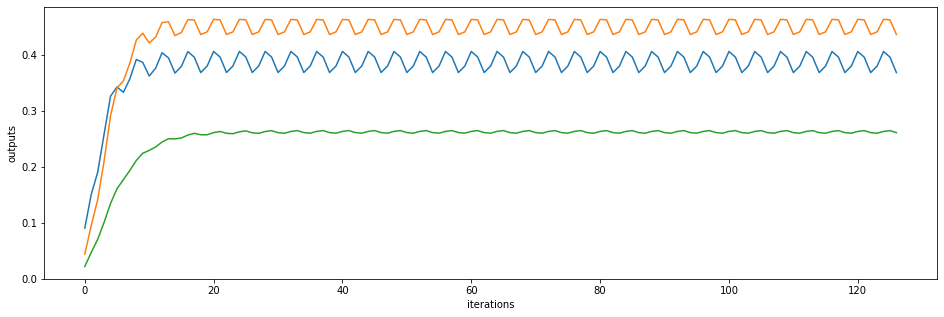

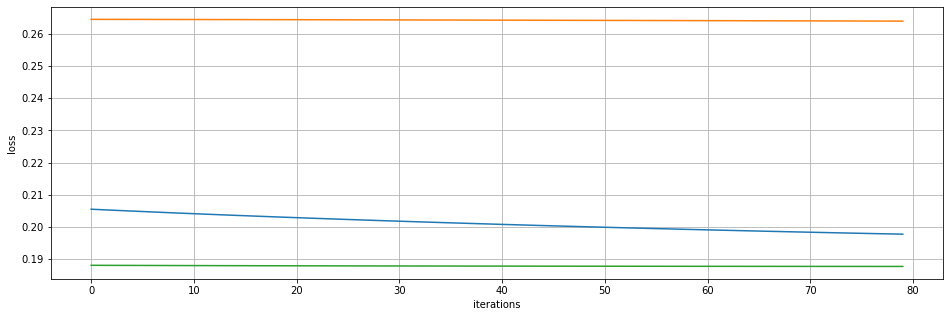

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 261
---------------
epoch 262
---------------
epoch 263
---------------
epoch 264
---------------
epoch 265
---------------
epoch 266
---------------
epoch 267
---------------
epoch 268
---------------
epoch 269
---------------
epoch 270
---------------
epoch 270
learning rate: 0.00467250990302522
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.19709081]
 [0.26388802]
 [0.18772894]]


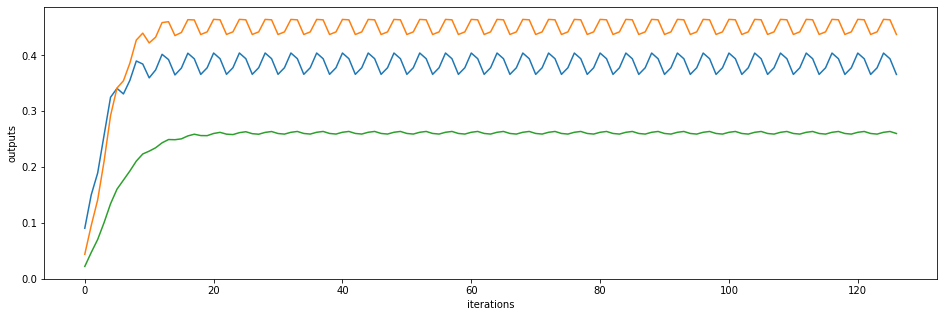

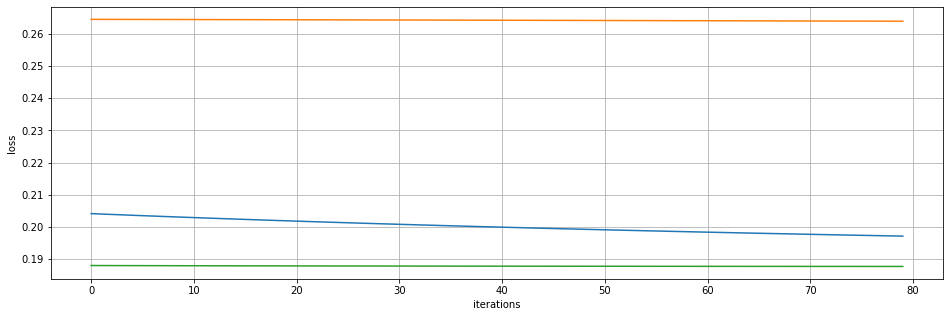

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 271
---------------
epoch 272
---------------
epoch 273
---------------
epoch 274
---------------
epoch 275
---------------
epoch 276
---------------
epoch 277
---------------
epoch 278
---------------
epoch 279
---------------
epoch 280
---------------
epoch 280
learning rate: 0.004660844673971733
sample 0
output: 
[[0.09037948]
 [0.0437091 ]
 [0.02190546]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.19652408]
 [0.26381137]
 [0.18771494]]


KeyboardInterrupt: 

In [174]:
epochs = 14000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
    network.learning_rate /= 1.00025
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 8)
  
        if e%10 == 0 and i%131 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("learning rate: " + str(network.learning_rate))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%10 == 0:        
        print("-----------------average loss: " + str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.grid()
        plt.show()
        network.predict(input_data)
        
        
    prevLoss = loss
    if e > 10:
        losses.append(loss/len(input_data))
    if e > 90:
        del losses[0]
    
    
print("------------training finished successfully!------------")
        

In [ ]:
print(str(network.layers[-1].weights_H))

In [ ]:
print(str(network.layers[-2].weights_X))

In [ ]:
print(str(network.layers[-2].H))